In [69]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import unidecode
import unicodedata
import re
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [33]:
# Cargamos el dataset
dfrent = pd.read_csv('Dataset/renting_Barcelona.csv', delimiter=',')

In [34]:
# Vemos que columnas tiene el dataset
print(dfrent.columns.tolist())

['id', 'price', 'currency', 'latitude', 'longitude', 'sq_meters', 'sq_meters_built', 'rooms', 'bathrooms', 'balcony', 'terrace', 'exterior', 'orientation', 'floor', 'rooftop', 'elevator', 'doorman', 'pool', 'ac', 'heating', 'year_built', 'quality', 'city', 'neighborhood', 'dist_city_center', 'furniture', 'garage', 'property_type', 'garden', 'closest_station', 'dist_closest_station', 'created_at', 'last_seen']


In [35]:
# Mostramos las dimensiones del dataset
print(f"Dimensiones del dataset: {dfrent.shape}")

Dimensiones del dataset: (8502, 33)


In [36]:
# Vemos los data types de las columnas
print("Tipos de datos de las columnas:")
print(dfrent.dtypes)

Tipos de datos de las columnas:
id                        int64
price                     int64
currency                 object
latitude                float64
longitude               float64
sq_meters               float64
sq_meters_built           int64
rooms                     int64
bathrooms                 int64
balcony                 float64
terrace                 float64
exterior                float64
orientation              object
floor                   float64
rooftop                 float64
elevator                float64
doorman                 float64
pool                    float64
ac                      float64
heating                  object
year_built              float64
quality                   int64
city                     object
neighborhood             object
dist_city_center        float64
furniture               float64
garage                  float64
property_type            object
garden                  float64
closest_station          object
dist_clo

In [37]:
dfrent.head(5)

,id,price,currency,latitude,longitude,sq_meters,sq_meters_built,rooms,bathrooms,balcony,...,neighborhood,dist_city_center,furniture,garage,property_type,garden,closest_station,dist_closest_station,created_at,last_seen
0,536625,850,€/mes,41.401708,2.154077,52.0,55,2,1,NaN,...,Gràcia,2.026455,3.0,NaN,piso,NaN,Fontana,0.094111,9/1/2021 15:58,10/4/2021 6:01
1,545910,725,€/mes,41.407221,2.135569,32.0,37,2,1,1.0,...,Sant Gervasi - La Bonanova,3.582409,NaN,NaN,piso,NaN,Vallcarca,0.902561,9/2/2021 15:24,9/8/2021 12:29
2,570697,950,€/mes,41.411508,2.164608,NaN,72,3,1,NaN,...,El Baix Guinardó,2.663025,3.0,NaN,piso,NaN,Alfons X,0.188177,8/28/2021 23:52,8/28/2021 23:52
3,591588,750,€/mes,41.402256,2.140764,NaN,45,1,1,1.0,...,Sant Gervasi - La Bonanova,2.910067,3.0,NaN,piso,NaN,Lesseps,0.892917,8/29/2021 11:25,9/8/2021 12:29
4,610243,990,€/mes,41.405327,2.146929,NaN,45,1,1,NaN,...,Sarrià-Sant Gervasi,2.727149,3.0,NaN,piso,NaN,Lesseps,0.293784,8/30/2021 13:48,8/30/2021 14:04


In [38]:
# Seleccionamos las columnas numericas (int64, float64)
numerical_columns = dfrent.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Mostramos los estadisticos descriptivos de las columnas numericas
display(dfrent[numerical_columns].describe())

,id,price,latitude,longitude,sq_meters,sq_meters_built,rooms,bathrooms,balcony,terrace,...,doorman,pool,ac,year_built,quality,dist_city_center,furniture,garage,garden,dist_closest_station
count,8.502000e+03,8502.000000,8502.000000,8502.000000,4967.000000,8502.000000,8502.000000,8502.000000,3485.0,1928.0,...,0.0,321.0,4086.0,4006.000000,8502.0,8502.000000,7250.0,385.0,51.0,8502.000000
mean,8.852101e+07,1117.482828,41.398106,2.162651,65.191464,72.478711,2.075394,1.265349,1.0,1.0,...,NaN,1.0,1.0,1950.885921,2.0,2.616749,3.0,1.0,1.0,0.392531
std,1.781127e+07,1010.198242,0.018344,0.020805,40.805539,49.650215,1.155006,0.602056,0.0,0.0,...,NaN,0.0,0.0,38.391917,0.0,1.409102,0.0,0.0,0.0,0.290708
min,5.366250e+05,365.000000,41.353583,2.102393,3.000000,11.000000,0.000000,1.000000,1.0,1.0,...,NaN,1.0,1.0,1783.000000,2.0,0.062165,3.0,1.0,1.0,0.007875
25%,9.235744e+07,768.250000,41.382177,2.146160,45.000000,50.000000,1.000000,1.000000,1.0,1.0,...,NaN,1.0,1.0,1930.000000,2.0,1.475110,3.0,1.0,1.0,0.225168
50%,9.505698e+07,850.000000,41.397202,2.164480,58.000000,63.000000,2.000000,1.000000,1.0,1.0,...,NaN,1.0,1.0,1962.000000,2.0,2.481490,3.0,1.0,1.0,0.325357
75%,9.519903e+07,1100.000000,41.409961,2.178082,71.000000,79.000000,3.000000,1.000000,1.0,1.0,...,NaN,1.0,1.0,1974.000000,2.0,3.589782,3.0,1.0,1.0,0.453814
max,9.589512e+07,27500.000000,41.467905,2.218582,672.000000,981.000000,11.000000,7.000000,1.0,1.0,...,NaN,1.0,1.0,2106.000000,2.0,8.940761,3.0,1.0,1.0,3.177445


In [39]:
# Checkeamos si hay valores nulos en todas las columnas
print("Valores nulos en el dataset:")
print(dfrent.isnull().sum())

Valores nulos en el dataset:
id                         0
price                      0
currency                   0
latitude                   0
longitude                  0
sq_meters               3535
sq_meters_built            0
rooms                      0
bathrooms                  0
balcony                 5017
terrace                 6574
exterior                 666
orientation             4816
floor                   1966
rooftop                 7885
elevator                 257
doorman                 8502
pool                    8181
ac                      4416
heating                 3030
year_built              4496
quality                    0
city                       0
neighborhood               0
dist_city_center           0
furniture               1252
garage                  8117
property_type              2
garden                  8451
closest_station            0
dist_closest_station       0
created_at                 0
last_seen                  0
dtype: int64


In [40]:
# Primero eliminamos las columnas del dataset ya que tienen un alto porcentaje de valores nulos
dfrent = dfrent.drop(columns=['rooftop', 'doorman', 'pool', 'orientation', 'garden', 'garage', 'furniture'])

In [41]:
# Vamos a aplicar codificacion binaria a las columnas categoricas
# Son: balcony, terrace, exterior, elevator y ac
binary_columns = ['balcony', 'terrace', 'exterior', 'elevator', 'ac']

# Reemplazamos los valores NaN por 0
dfrent[binary_columns] = dfrent[binary_columns].fillna(0)

# Nos aseguramos que todos los datos de estas columnas son binarios 1 o 0
for col in binary_columns:
    dfrent[col] = dfrent[col].apply(lambda x: 1 if x else 0)

In [42]:
# Seleccionamos solo columnas numéricas relevantes para estimar 'year_built'
cols_for_imputation = ['price', 'sq_meters_built', 'rooms', 'bathrooms', 'quality', 'year_built']
impute_df = dfrent[cols_for_imputation].copy()

# Normalizamos las columnas
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(impute_df)

# Aplicamos KNNImputer
imputer = KNNImputer(n_neighbors=5)
imputed_data = imputer.fit_transform(scaled_data)

# Deshacemos la normalización solo para 'year_built'
imputed_df = pd.DataFrame(scaler.inverse_transform(imputed_data), columns=cols_for_imputation)

# Reemplazamos los valores en dfbcn
dfrent['year_built'] = imputed_df['year_built'].round().astype(int)

In [43]:
# Imputamos los NaNs de property_type con su valor más frecuente (moda)
dfrent['property_type'] = dfrent['property_type'].fillna(dfrent['property_type'].mode()[0])

In [44]:
# Imputamos "floor" por media según "neighborhood"
dfrent['floor'] = dfrent.groupby('neighborhood')['floor'].transform(lambda x: x.fillna(x.mean()))

In [45]:
# Imputamos "heating" por moda dentro de bins de year_built
dfrent['year_built_bin'] = pd.qcut(dfrent['year_built'], q=5, duplicates='drop')
dfrent['heating'] = dfrent.groupby('year_built_bin')['heating'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)
dfrent.drop(columns=['year_built_bin'], inplace=True)

C:\Users\heatb\AppData\Local\Temp\ipykernel_19296\105022179.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  dfrent['heating'] = dfrent.groupby('year_built_bin')['heating'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.mode().empty else x)


In [46]:
# Imputamos "sq_meters" con KMeans basado en variables relacionadas
# Variables predictoras para KMeans (deben no tener nulos)
km_df = dfrent[['sq_meters', 'sq_meters_built', 'rooms', 'price']].dropna()

# Entrenamos KMeans
kmeans = KMeans(n_clusters=5, random_state=0)
km_df['cluster'] = kmeans.fit_predict(km_df[['sq_meters_built', 'rooms', 'price']])

# Calculamos media por cluster
cluster_means = km_df.groupby('cluster')['sq_meters'].mean()

# Etiquetamos clusters en todo dfrent (donde hay info)
def assign_cluster(row):
    if pd.isna(row['sq_meters']):
        return kmeans.predict([[row['sq_meters_built'], row['rooms'], row['price']]])[0]
    else:
        return np.nan

dfrent['cluster'] = dfrent.apply(assign_cluster, axis=1)

# Imputar con media del cluster
dfrent['sq_meters'] = dfrent.apply(
    lambda row: cluster_means[row['cluster']] if pd.isna(row['sq_meters']) else row['sq_meters'], axis=1
)

# Limpieza final
dfrent.drop(columns=['cluster'], inplace=True)

c:\Users\heatb\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
c:\Users\heatb\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
c:\Users\heatb\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
c:\Users\heatb\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
c:\Users\heatb\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(
c:\Users\heatb\anaconda3\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KMeans was fitted with

In [47]:
if dfrent.isnull().sum().sum() == 0:
    print("✅ Todos los valores nulos han sido imputados correctamente.")
else:
    print("⚠️ Aún quedan valores nulos en el dataset:")
    print(dfrent.isnull().sum()[dfrent.isnull().sum() > 0])

✅ Todos los valores nulos han sido imputados correctamente.


In [48]:
# Revisitamos los estadisticos descriptivos tras la imputación
numerical_columns2 = dfrent.select_dtypes(include=['int64', 'float64']).columns.tolist()
display(dfrent[numerical_columns2].describe())

,id,price,latitude,longitude,sq_meters,sq_meters_built,rooms,bathrooms,balcony,terrace,exterior,floor,elevator,ac,quality,dist_city_center,dist_closest_station
count,8.502000e+03,8502.000000,8502.000000,8502.000000,8502.000000,8502.000000,8502.000000,8502.000000,8502.000000,8502.000000,8502.000000,8502.000000,8502.000000,8502.000000,8502.0,8502.000000,8502.000000
mean,8.852101e+07,1117.482828,41.398106,2.162651,66.662899,72.478711,2.075394,1.265349,0.409904,0.226770,0.811103,3.042673,0.663138,0.480593,2.0,2.616749,0.392531
std,1.781127e+07,1010.198242,0.018344,0.020805,39.005620,49.650215,1.155006,0.602056,0.491845,0.418767,0.391450,1.860690,0.472665,0.499653,0.0,1.409102,0.290708
min,5.366250e+05,365.000000,41.353583,2.102393,3.000000,11.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.0,0.062165,0.007875
25%,9.235744e+07,768.250000,41.382177,2.146160,54.000000,50.000000,1.000000,1.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000,2.0,1.475110,0.225168
50%,9.505698e+07,850.000000,41.397202,2.164480,56.838981,63.000000,2.000000,1.000000,0.000000,0.000000,1.000000,3.000000,1.000000,0.000000,2.0,2.481490,0.325357
75%,9.519903e+07,1100.000000,41.409961,2.178082,65.000000,79.000000,3.000000,1.000000,1.000000,0.000000,1.000000,4.000000,1.000000,1.000000,2.0,3.589782,0.453814
max,9.589512e+07,27500.000000,41.467905,2.218582,672.000000,981.000000,11.000000,7.000000,1.000000,1.000000,1.000000,29.000000,1.000000,1.000000,2.0,8.940761,3.177445


Ahora que hemos terminado del limpiar los valores nulos del dataset, nos disponemos a agrupar los barrios por distritos para tener una mayor granulación y homogeneidad a la hora de hacer calculos con esta variable.

In [49]:
# Diccionario barrio → distrito con nombres normalizados (sin tildes, minúsculas, sin espacios extra)
barrio_a_distrito = {
    # Sarrià - Sant Gervasi
    'el putxet i el farro': 'Sarrià - Sant Gervasi',
    'sarria': 'Sarrià - Sant Gervasi',
    'sant gervasi - la bonanova': 'Sarrià - Sant Gervasi',
    'sant gervasi - galvany': 'Sarrià - Sant Gervasi',
    'les tres torres': 'Sarrià - Sant Gervasi',
    'vallvidrera, el tibidabo i les planes': 'Sarrià - Sant Gervasi',

    # Sants - Montjuïc
    'la bordeta': 'Sants - Montjuïc',
    'la font de la guatlla': 'Sants - Montjuïc',
    'hostafrancs': 'Sants - Montjuïc',
    'la marina de port': 'Sants - Montjuïc',
    'la marina del prat vermell': 'Sants - Montjuïc',
    'el poble-sec': 'Sants - Montjuïc',
    'sants': 'Sants - Montjuïc',
    'sants-badal': 'Sants - Montjuïc',

    # Les Corts
    'les corts': 'Les Corts',
    'la maternitat i sant ramon': 'Les Corts',
    'pedralbes': 'Les Corts',

    # Ciutat Vella
    'la barceloneta': 'Ciutat Vella',
    'el gotic': 'Ciutat Vella',
    'el raval': 'Ciutat Vella',
    'sant pere, santa caterina i la ribera': 'Ciutat Vella',

    # L'Eixample
    'l antiga esquerra de l eixample': "L'Eixample",
    'la nova esquerra de l eixample': "L'Eixample",
    'la dreta de l eixample': "L'Eixample",
    'el fort pienc': "L'Eixample",
    'la sagrada familia': "L'Eixample",
    'sant antoni': "L'Eixample",

    # Gràcia
    'la vila de gracia': 'Gràcia',
    'el camp d en grassot i gracia nova': 'Gràcia',
    'la salut': 'Gràcia',
    'el coll': 'Gràcia',
    'vallcarca i els penitents': 'Gràcia',

    # Horta - Guinardó
    'el baix guinardo': 'Horta - Guinardó',
    'el guinardo': 'Horta - Guinardó',
    'can baro': 'Horta - Guinardó',
    'el carmel': 'Horta - Guinardó',
    'la font d en fargues': 'Horta - Guinardó',
    'horta': 'Horta - Guinardó',
    'la clota': 'Horta - Guinardó',
    'montbau': 'Horta - Guinardó',
    'sant genis dels agudells': 'Horta - Guinardó',
    'la teixonera': 'Horta - Guinardó',
    'la vall d hebron': 'Horta - Guinardó',

    # Nou Barris
    'can peguera': 'Nou Barris',
    'canyelles': 'Nou Barris',
    'ciutat meridiana': 'Nou Barris',
    'la guineueta': 'Nou Barris',
    'porta': 'Nou Barris',
    'la prosperitat': 'Nou Barris',
    'les roquetes': 'Nou Barris',
    'torre baro': 'Nou Barris',
    'la trinitat nova': 'Nou Barris',
    'el turo de la peira': 'Nou Barris',
    'vallbona': 'Nou Barris',
    'verdum': 'Nou Barris',
    'vilapicina i la torre llobeta': 'Nou Barris',

    # Sant Andreu
    'baro de viver': 'Sant Andreu',
    'el bon pastor': 'Sant Andreu',
    'el congres i els indians': 'Sant Andreu',
    'navas': 'Sant Andreu',
    'sant andreu de palomar': 'Sant Andreu',
    'la sagrera': 'Sant Andreu',
    'la trinitat vella': 'Sant Andreu',

    # Sant Martí
    'el besos i el maresme': 'Sant Martí',
    'el clot': 'Sant Martí',
    'el camp de l arpa del clot': 'Sant Martí',
    'diagonal mar i el front maritim del poblenou': 'Sant Martí',
    'el parc i la llacuna del poblenou': 'Sant Martí',
    'el poblenou': 'Sant Martí',
    'provencals del poblenou': 'Sant Martí',
    'sant marti de provencals': 'Sant Martí',
    'la verneda i la pau': 'Sant Martí',
    'la vila olimpica del poblenou': 'Sant Martí'
}


In [50]:
# Añadir asociaciones adicionales de barrios no reconocidos
barrio_a_distrito.update({
    'gracia': 'Gràcia',
    'sarria-sant gervasi': 'Sarrià - Sant Gervasi',
    'vila de gracia': 'Gràcia',
    'eixample': "L'Eixample",
    'sants - badal': 'Sants - Montjuïc',
    'la nova esquerra de l eixample': "L'Eixample",
    'l antiga esquerra de l eixample': "L'Eixample",
    'el poble sec - parc de montjuic': 'Sants - Montjuïc',
    'el camp d en grassot i gracia nova': 'Gràcia',
    'el camp de l arpa del clot': 'Horta - Guinardó',
    'la dreta de l eixample': "L'Eixample",
    'ciutat vella': 'Ciutat Vella',
    'sant pere - santa caterina i la ribera': 'Ciutat Vella',
    'horta guinardo': 'Horta - Guinardó',
    'sant andreu': 'Sant Andreu',
    'nou barris': 'Nou Barris',
    'sants-montjuic': 'Sants - Montjuïc',
    'la font d en fargues': 'Horta - Guinardó',
    'el besos': 'Sant Martí',
    'sant genis dels agudells - montbau': 'Horta - Guinardó',
    'la vall d hebron - la clota': 'Horta - Guinardó',
    'can peguera - el turo de la peira': 'Nou Barris',
    'sant marti': 'Sant Martí',
    'la marina del port': 'Sants - Montjuïc',
    'verdun': 'Nou Barris',
    'ciutat meridiana - torre baro - vallbona': 'Nou Barris',
    'vallvidrera - el tibidabo i les planes': 'Sarrià - Sant Gervasi',
})


In [51]:
def clean_text(text):
    if pd.isnull(text):
        return ''
    return unidecode.unidecode(text.lower().strip())

# Crear columna limpia
dfrent['neighborhood_clean'] = dfrent['neighborhood'].apply(clean_text)

In [52]:
def limpiar_texto(texto):
    if pd.isnull(texto):
        return ''
    # Quitar acentos y normalizar
    texto = ''.join(c for c in unicodedata.normalize('NFD', texto) if unicodedata.category(c) != 'Mn')
    # Pasar a minúsculas
    texto = texto.lower()
    # Reemplazar apóstrofes, guiones y caracteres raros por espacios
    texto = texto.replace("'", ' ').replace('-', ' ')
    # Eliminar caracteres no alfanuméricos (excepto espacios)
    texto = re.sub(r'[^a-z0-9\s]', '', texto)
    # Eliminar múltiples espacios
    texto = re.sub(r'\s+', ' ', texto).strip()
    return texto

In [53]:
# Limpiamos tanto los nombres del diccionario como los del DataFrame
dfrent['neighborhood_clean'] = dfrent['neighborhood'].apply(limpiar_texto)
barrio_a_distrito_limpio = {limpiar_texto(k): v for k, v in barrio_a_distrito.items()}

In [54]:
# Asignamos los distritos usando el diccionario limpio
dfrent['district'] = dfrent['neighborhood_clean'].map(barrio_a_distrito_limpio)

In [55]:
# Verificamos si hay barrios sin distrito asignado
barrios_no_asignados = dfrent[dfrent['district'].isnull()]['neighborhood'].unique()
print("Barrios no asignados:\n", barrios_no_asignados)

Barrios no asignados:
 []


Ahora procedemos a hacer los análisis univariables y bivariables para ver que insights podemos extraer a simple vista. Otro de los factores más importantes también será el tratamiento de outliers. 

In [56]:
# Filtrar solo pisos de Barcelona para mayor claridad
df_barcelona = dfrent[dfrent['city'] == 'Barcelona'].copy()

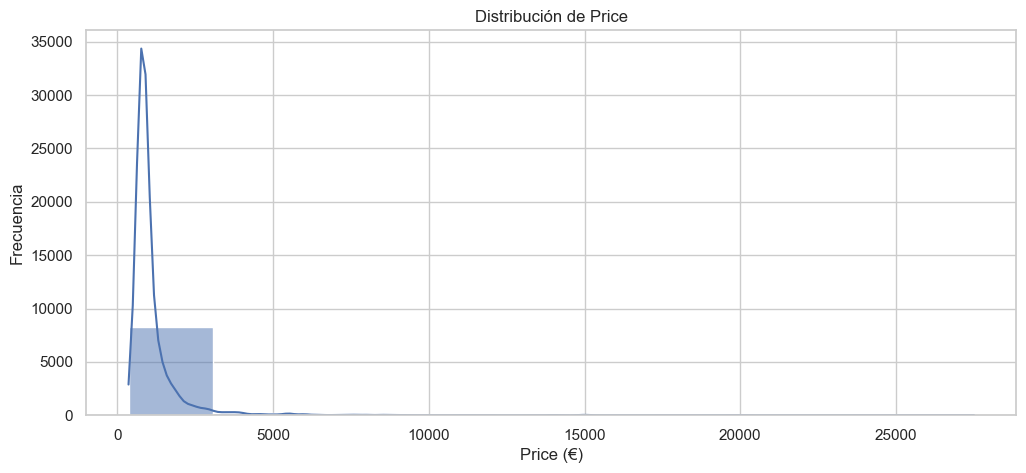

In [57]:
# Para gráficos más bonitos
sns.set(style="whitegrid")

# Histograma + KDE de price para ver distribución y posibles outliers
plt.figure(figsize=(12,5))
sns.histplot(df_barcelona['price'], bins=10, kde=True)
plt.title('Distribución de Price')
plt.xlabel('Price (€)')
plt.ylabel('Frecuencia')
plt.show()


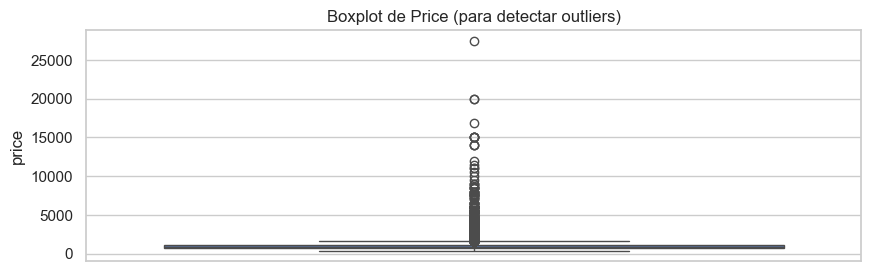

In [58]:
# Boxplot para detectar outliers de price
plt.figure(figsize=(10,3))
sns.boxplot(y=df_barcelona['price'])
plt.title('Boxplot de Price (para detectar outliers)')
plt.show()

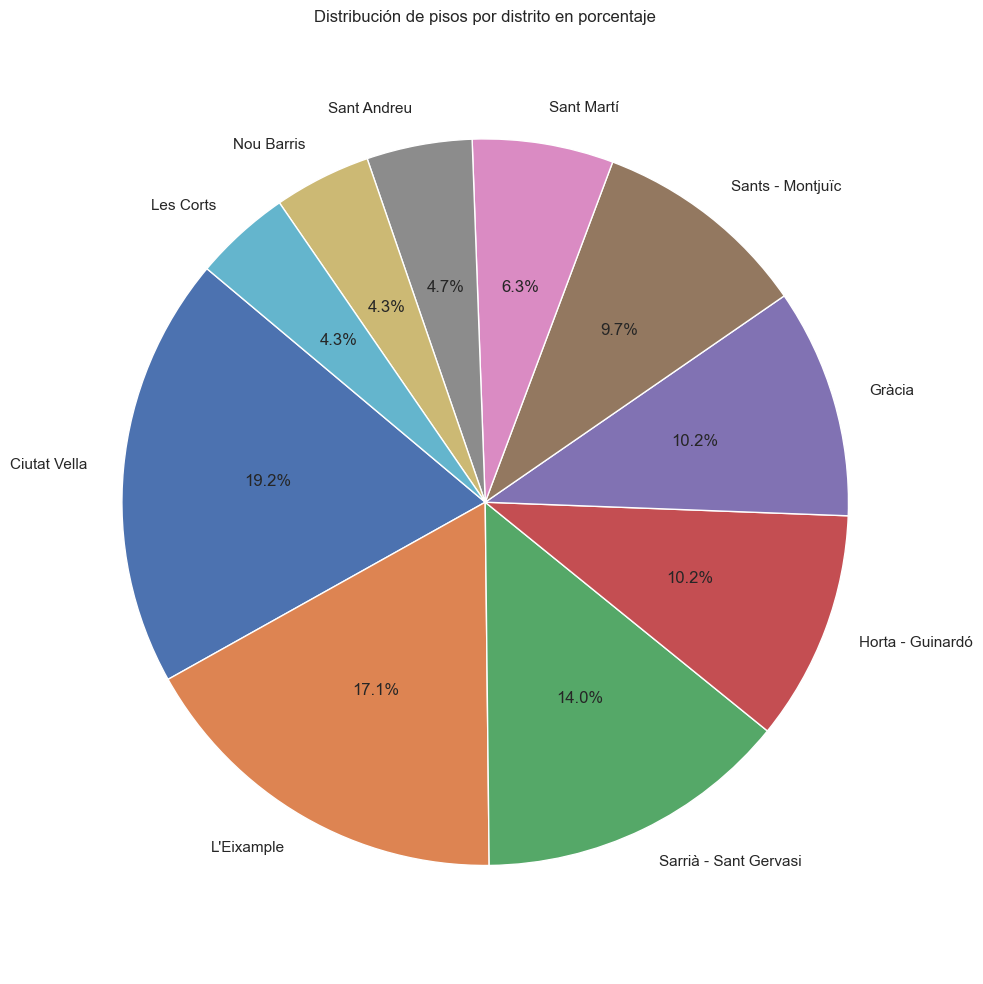

In [59]:
# Gráfico de pastel de distribución de pisos por distrito en portcentaje

# Conteo de pisos por distrito
district_counts = dfrent['district'].value_counts()

# Crear gráfico de pastel
plt.figure(figsize=(10, 10))
plt.pie(district_counts, labels=district_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución de pisos por distrito en porcentaje')
plt.axis('equal')  # Hace el gráfico circular
plt.tight_layout()
plt.show()

C:\Users\heatb\AppData\Local\Temp\ipykernel_19296\2680806334.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=price_by_neigh.values, x=price_by_neigh.index, palette="viridis")


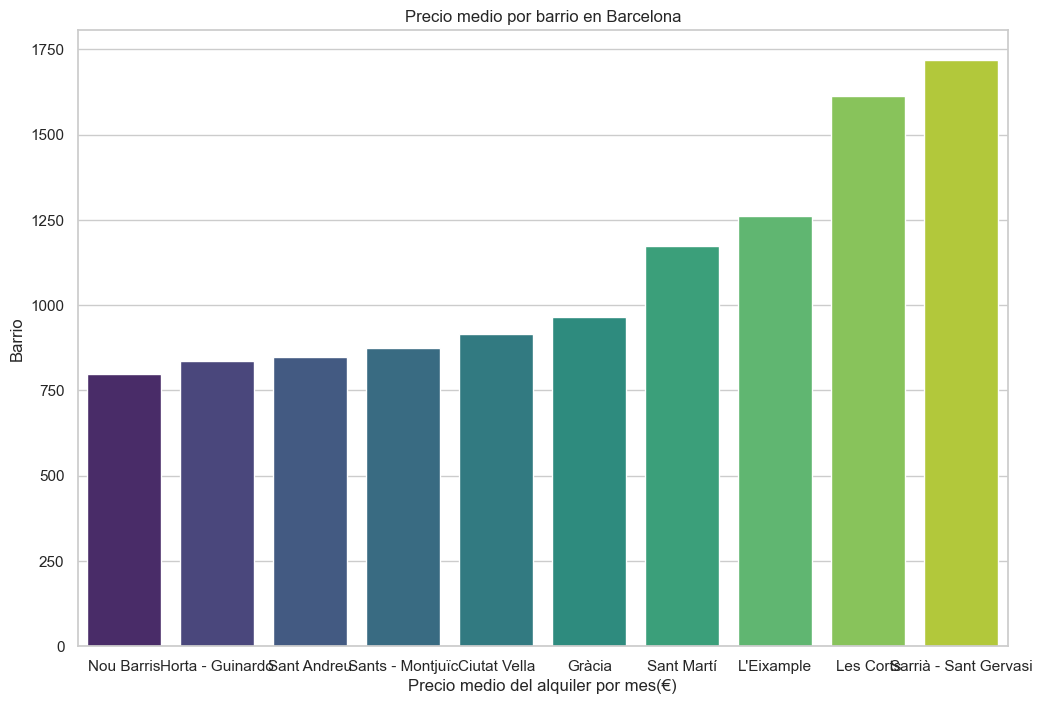

In [60]:
# Precio medio según barrio (neighborhood)
price_by_neigh = df_barcelona.groupby('district')['price'].mean().sort_values()

plt.figure(figsize=(12, 8))
sns.barplot(y=price_by_neigh.values, x=price_by_neigh.index, palette="viridis")
plt.title('Precio medio por barrio en Barcelona')
plt.xlabel('Precio medio del alquiler por mes(€)')
plt.ylabel('Barrio')
plt.show()

C:\Users\heatb\AppData\Local\Temp\ipykernel_19296\344834869.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=dfrent, x='district', y='price', palette='Set3')


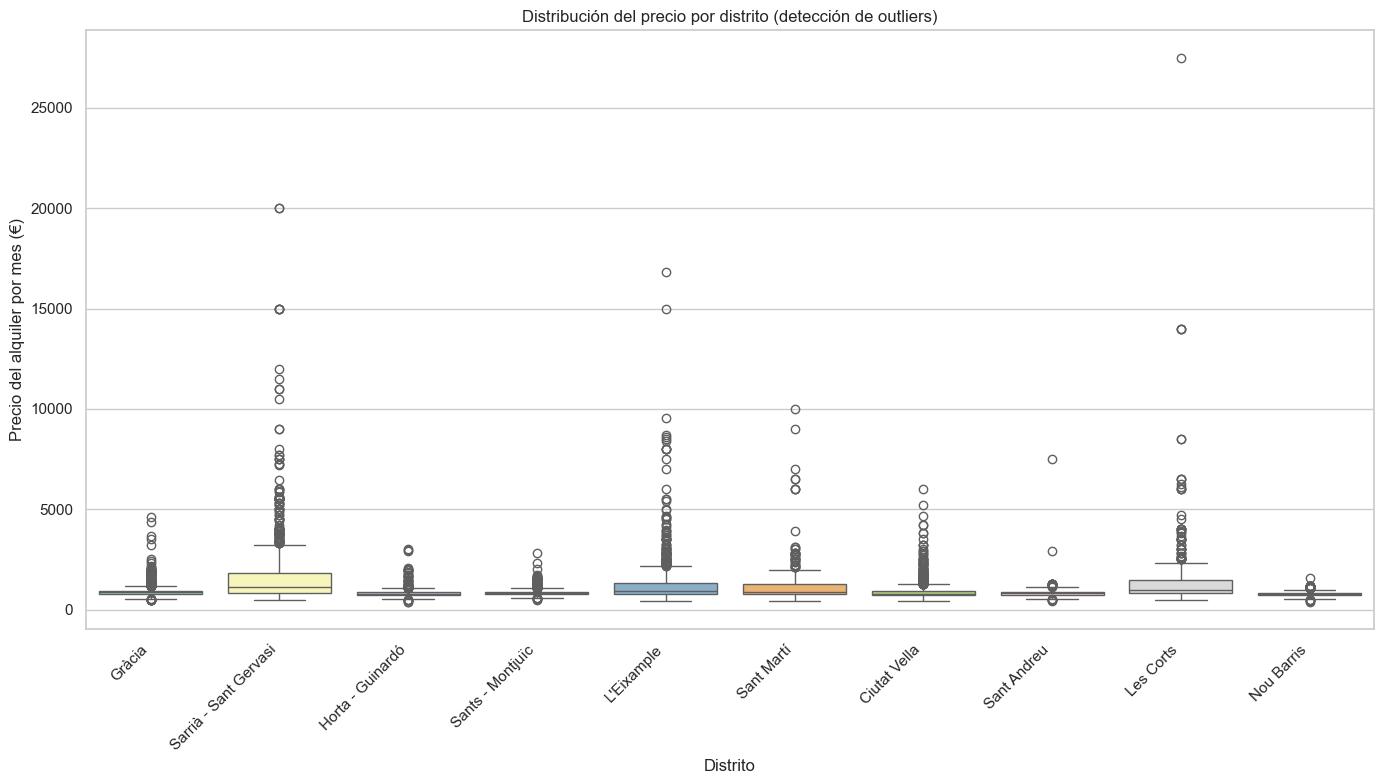

In [61]:
# Gráfico de boxplot para ver la distribución del precio por distrito y detectar outliers
# Configurar el tamaño del gráfico
plt.figure(figsize=(14, 8))

# Crear el boxplot
sns.boxplot(data=dfrent, x='district', y='price', palette='Set3')

# Rotar etiquetas del eje X si es necesario
plt.xticks(rotation=45, ha='right')

# Título y etiquetas
plt.title('Distribución del precio por distrito (detección de outliers)')
plt.xlabel('Distrito')
plt.ylabel('Precio del alquiler por mes (€)')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

C:\Users\heatb\AppData\Local\Temp\ipykernel_19296\1201520006.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=dfrent, x='district', y='price', palette='Pastel1', cut=0)


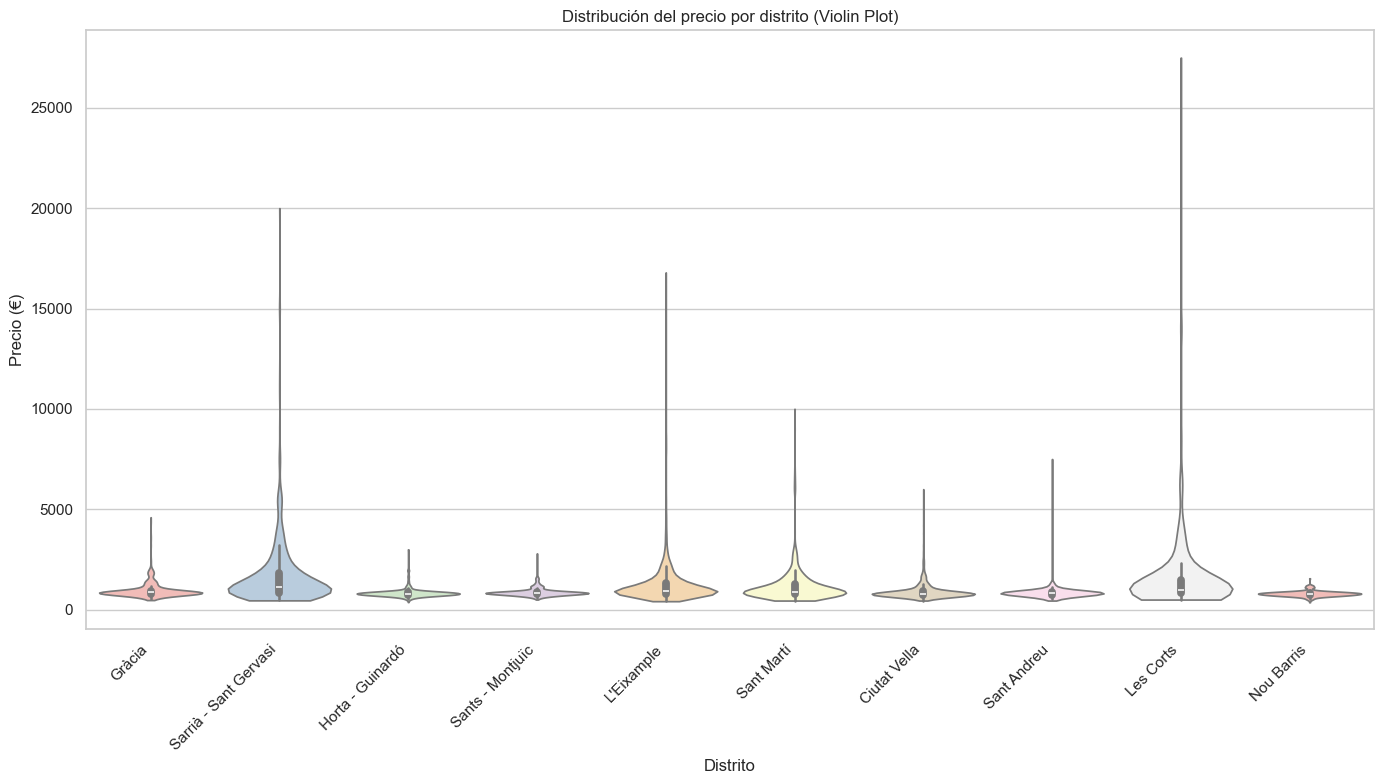

In [62]:
# Configuramos el tamaño del gráfico
plt.figure(figsize=(14, 8))

# Crear el gráfico de violín
sns.violinplot(data=dfrent, x='district', y='price', palette='Pastel1', cut=0)

# Rotar etiquetas del eje X
plt.xticks(rotation=45, ha='right')

# Título y etiquetas
plt.title('Distribución del precio por distrito (Violin Plot)')
plt.xlabel('Distrito')
plt.ylabel('Precio (€)')

# Mostrar el gráfico
plt.tight_layout()
plt.show()

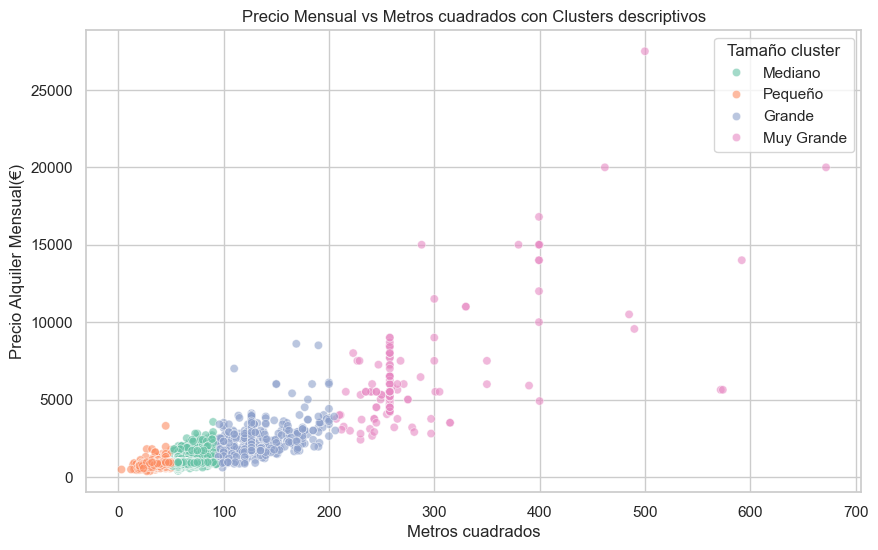

In [63]:
# Precio medio en relación a metros cuadrados con clustering
# Filtrar datos válidos
mask_sq = df_barcelona['sq_meters'] > 0
df_clust = df_barcelona.loc[mask_sq, ['sq_meters', 'price']].copy()

kmeans = KMeans(n_clusters=4, random_state=42)
df_clust['cluster'] = kmeans.fit_predict(df_clust[['sq_meters']])

# Calcular medias para asignar etiquetas
cluster_stats = df_clust.groupby('cluster')['sq_meters'].mean().sort_values()
cluster_labels = ['Pequeño', 'Mediano', 'Grande', 'Muy Grande']
# Mapear cluster a etiqueta
cluster_map = dict(zip(cluster_stats.index, cluster_labels))
df_clust['cluster_label'] = df_clust['cluster'].map(cluster_map)

plt.figure(figsize=(10,6))
sns.scatterplot(data=df_clust, x='sq_meters', y='price', hue='cluster_label', palette='Set2', alpha=0.6)
plt.title('Precio Mensual vs Metros cuadrados con Clusters descriptivos')
plt.xlabel('Metros cuadrados')
plt.ylabel('Precio Alquiler Mensual(€)')
plt.legend(title='Tamaño cluster')
plt.show()

C:\Users\heatb\AppData\Local\Temp\ipykernel_19296\560463587.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=price_by_rooms.index, y=price_by_rooms.values, palette="Blues_d")


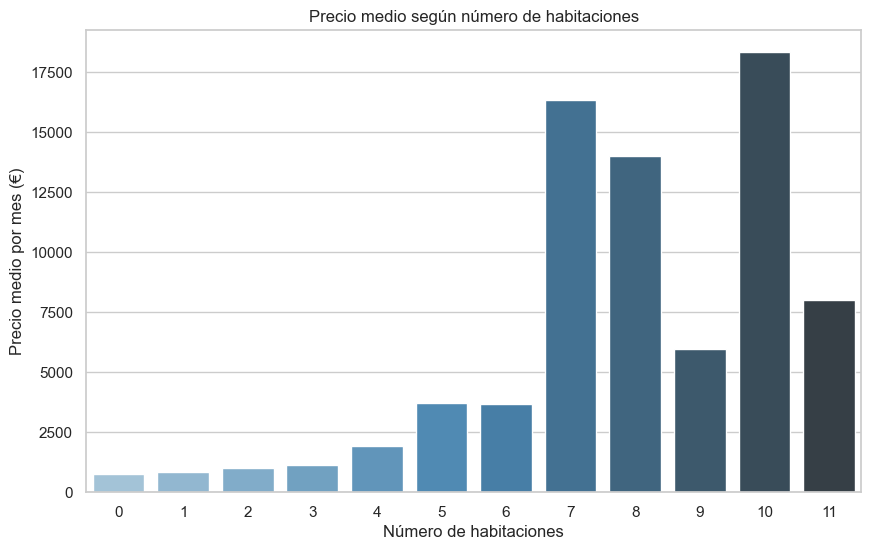

In [64]:
# Precio medio según número de habitaciones
plt.figure(figsize=(10,6))
price_by_rooms = df_barcelona.groupby('rooms')['price'].mean().sort_index()
sns.barplot(x=price_by_rooms.index, y=price_by_rooms.values, palette="Blues_d")
plt.title('Precio medio según número de habitaciones')
plt.xlabel('Número de habitaciones')
plt.ylabel('Precio medio por mes (€)')
plt.show()

C:\Users\heatb\AppData\Local\Temp\ipykernel_19296\4018768405.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=price_by_bathrooms.index, y=price_by_bathrooms.values, palette="Greens_d")


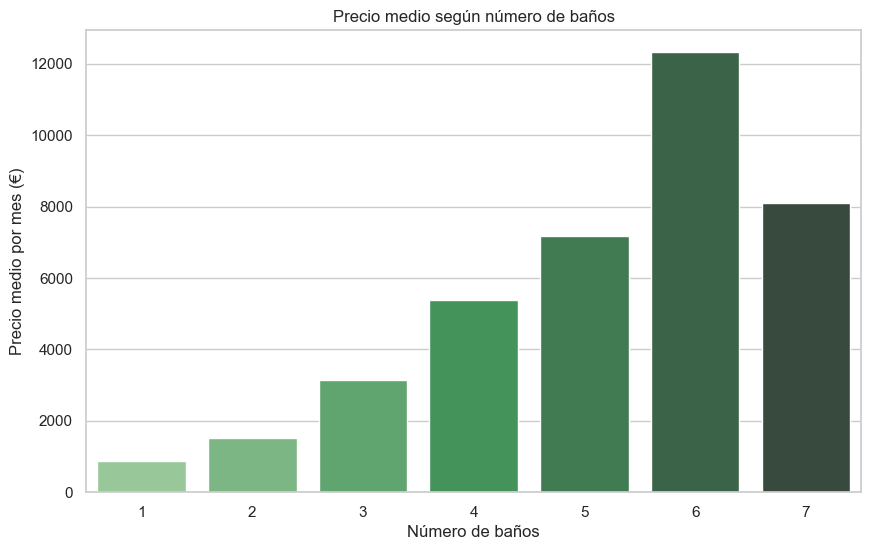

In [65]:
# Precio medio según número de baños
plt.figure(figsize=(10,6))
price_by_bathrooms = dfrent.groupby('bathrooms')['price'].mean().sort_index()
sns.barplot(x=price_by_bathrooms.index, y=price_by_bathrooms.values, palette="Greens_d")
plt.title('Precio medio según número de baños')
plt.xlabel('Número de baños')
plt.ylabel('Precio medio por mes (€)')
plt.show()

C:\Users\heatb\AppData\Local\Temp\ipykernel_19296\1726575583.py:25: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\heatb\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


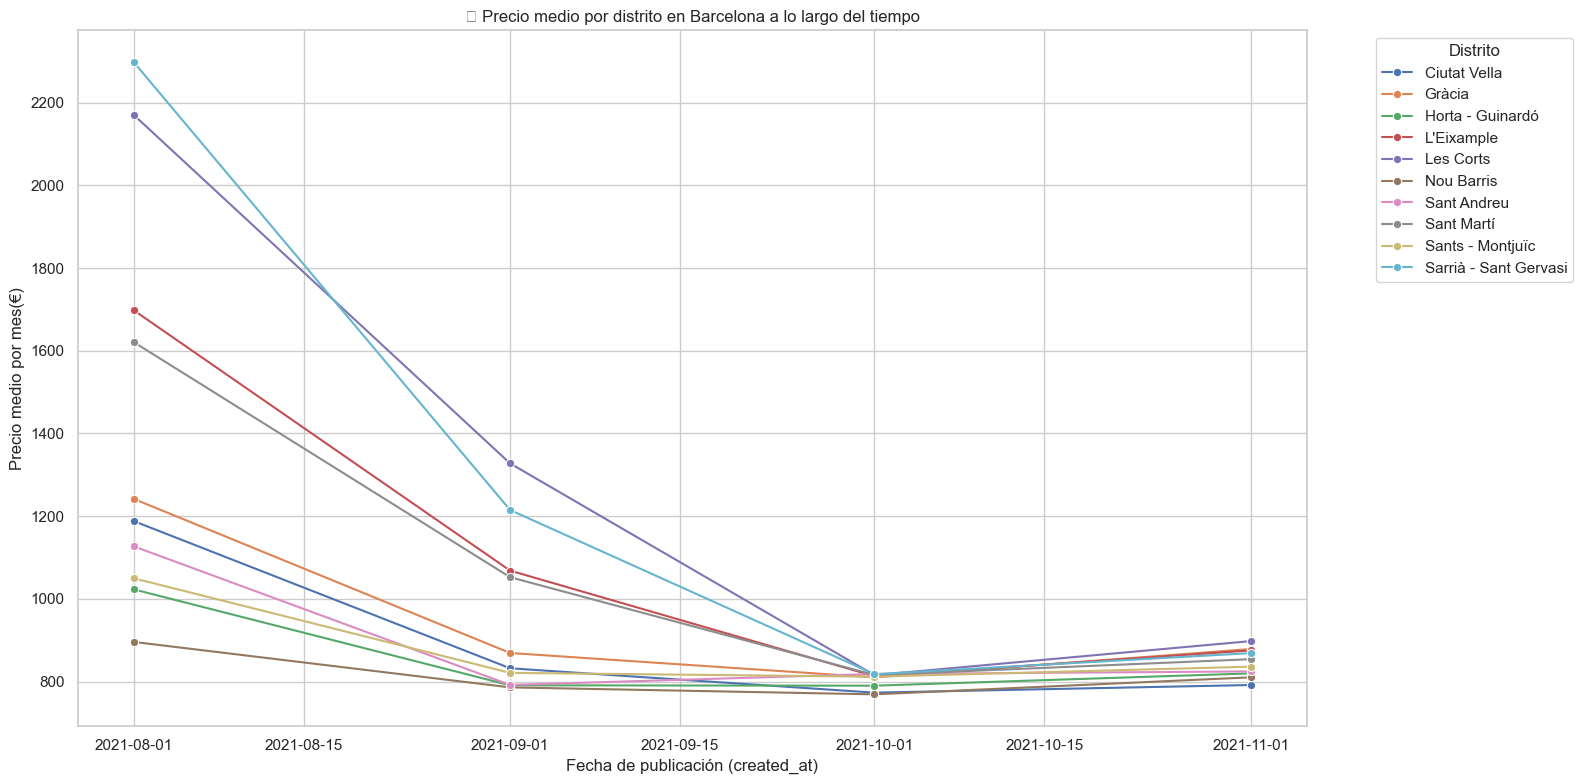

In [68]:
# Asegurar que created_at es datetime
df_barcelona['created_at'] = pd.to_datetime(df_barcelona['created_at'])

# Agrupación por mes y distrito
precio_tiempo = (
    df_barcelona
    .groupby([df_barcelona['created_at'].dt.to_period('M'), 'district'])['price']
    .mean()
    .reset_index()
)

# Convertir Period a Timestamp para graficar
precio_tiempo['created_at'] = precio_tiempo['created_at'].dt.to_timestamp()

# Plot
plt.figure(figsize=(16, 8))
sns.lineplot(data=precio_tiempo, x='created_at', y='price', hue='district', marker='o')

# Estética
plt.title('📊 Precio medio por distrito en Barcelona a lo largo del tiempo')
plt.xlabel('Fecha de publicación (created_at)')
plt.ylabel('Precio medio por mes(€)')
plt.legend(title='Distrito', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\heatb\AppData\Local\Temp\ipykernel_19296\1083464704.py:22: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  plt.tight_layout()
c:\Users\heatb\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128197 (\N{CALENDAR}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


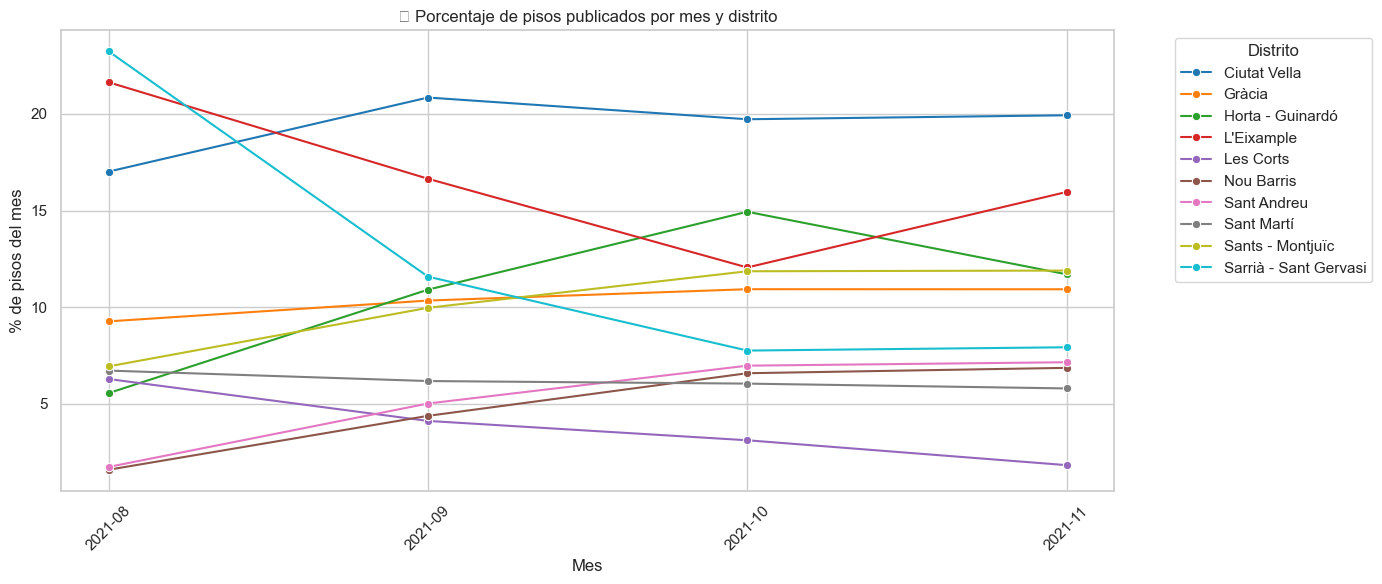

In [72]:
# Aseguramos que created_at es tipo datetime
df_barcelona['created_at'] = pd.to_datetime(df_barcelona['created_at'])

# Extraemos mes-año para agregación
df_barcelona['month'] = df_barcelona['created_at'].dt.to_period('M').astype(str)

# Agrupamos número de pisos por distrito y mes
grupo = df_barcelona.groupby(['district', 'month']).size().reset_index(name='count')

# Calculamos el total por mes para sacar el % dentro de cada mes
grupo['total_mes'] = grupo.groupby('month')['count'].transform('sum')
grupo['porcentaje'] = grupo['count'] / grupo['total_mes'] * 100

# Gráfico
plt.figure(figsize=(14, 6))
sns.lineplot(data=grupo, x='month', y='porcentaje', hue='district', marker='o', palette='tab10')
plt.title('📅 Porcentaje de pisos publicados por mes y distrito')
plt.ylabel('% de pisos del mes')
plt.xlabel('Mes')
plt.xticks(rotation=45)
plt.legend(title='Distrito', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

C:\Users\heatb\AppData\Local\Temp\ipykernel_19296\3535913154.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g = sns.catplot(


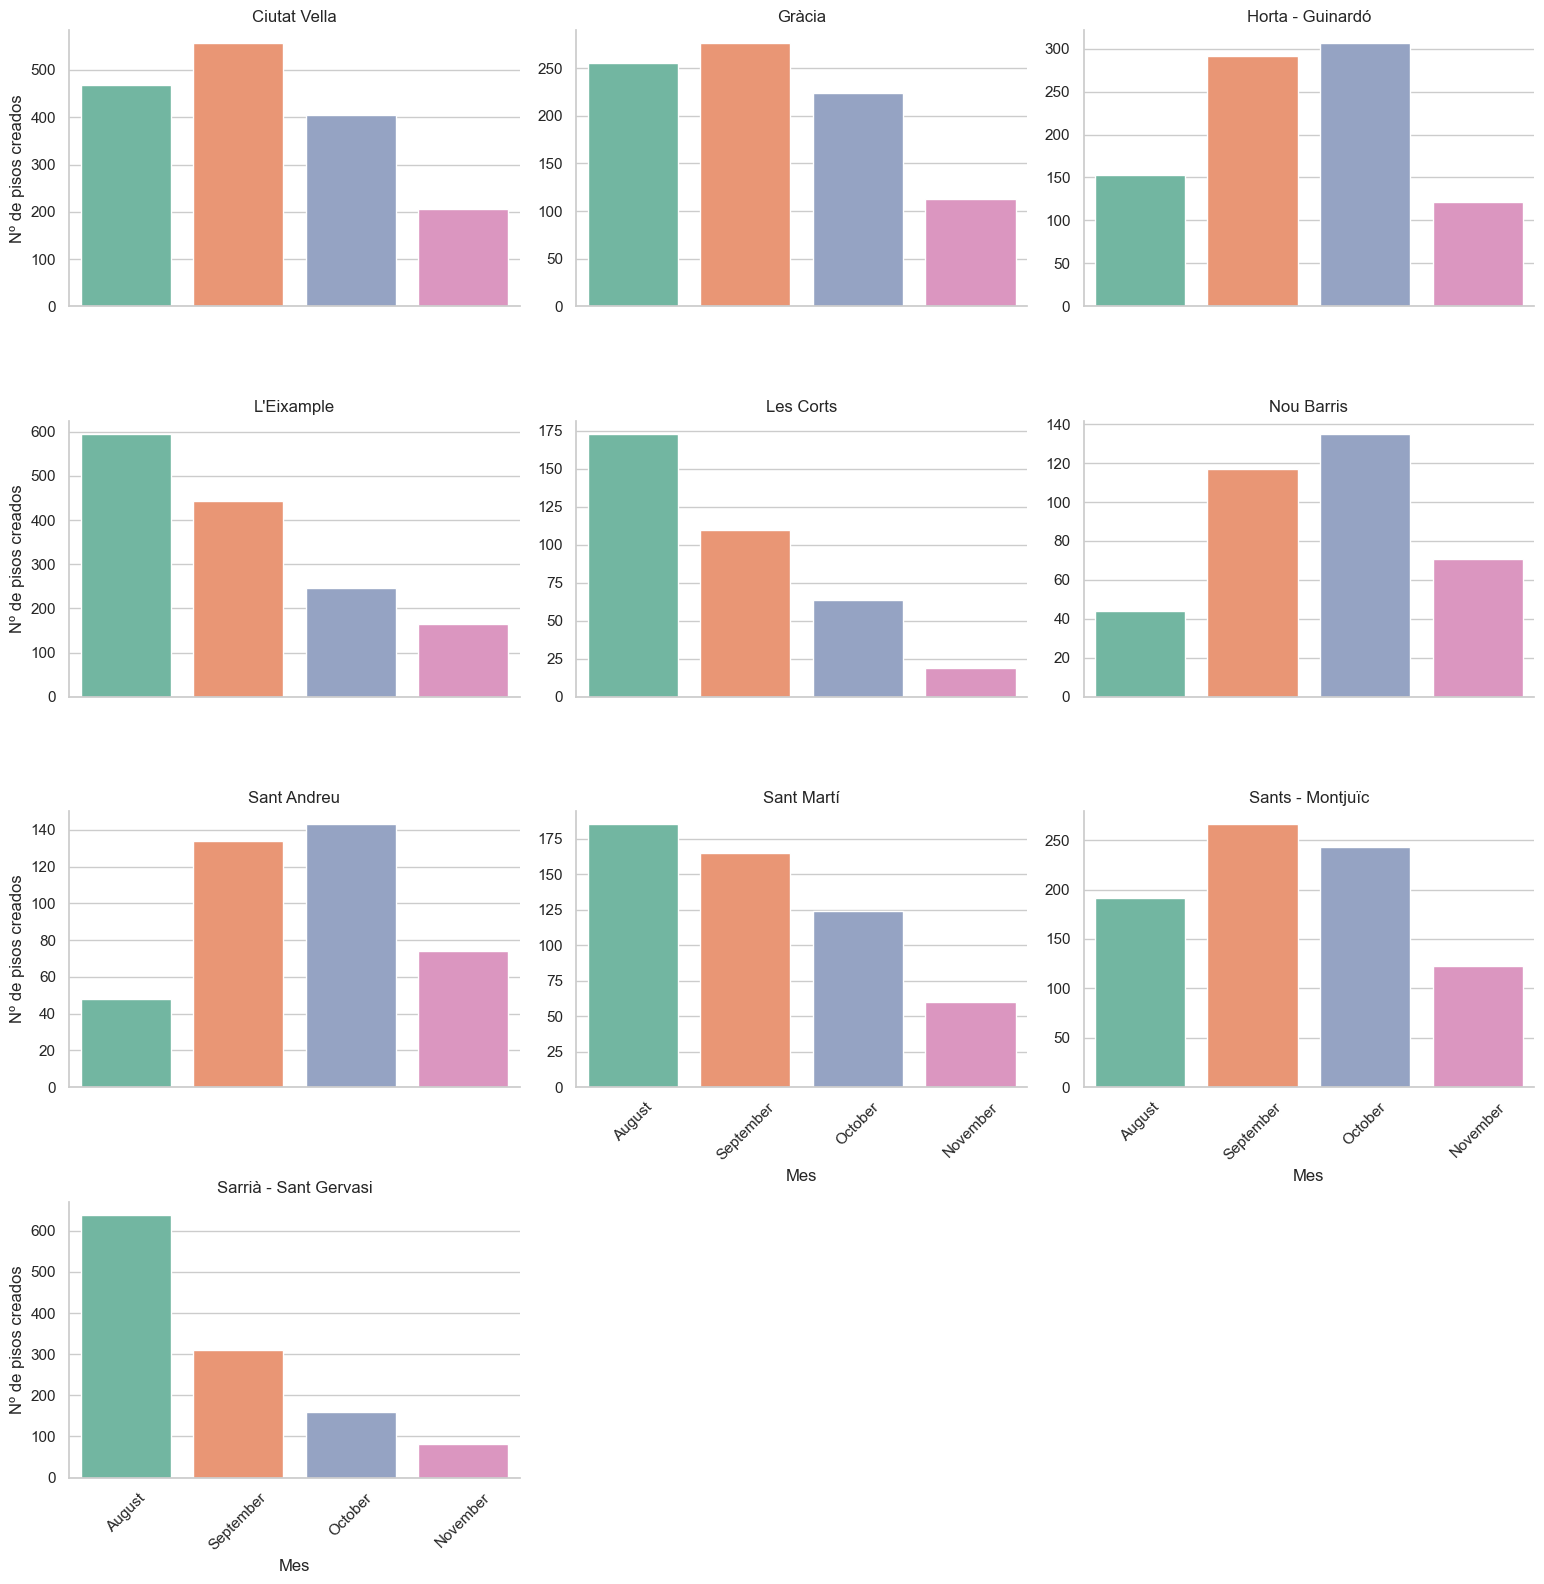

In [75]:
# Asegúrate de que created_at es datetime
df_barcelona['created_at'] = pd.to_datetime(df_barcelona['created_at'], errors='coerce')

# Extraer el nombre del mes
df_barcelona['mes'] = df_barcelona['created_at'].dt.strftime('%B')  # Nombre del mes
df_barcelona['mes_num'] = df_barcelona['created_at'].dt.month       # Para ordenar

# Agrupamos por distrito y mes
conteo = df_barcelona.groupby(['district', 'mes', 'mes_num']).size().reset_index(name='count')

# Ordenamos los meses correctamente
conteo = conteo.sort_values(by=['mes_num', 'district'])

# Configuramos el gráfico
g = sns.catplot(
    data=conteo,
    kind='bar',
    x='mes',
    y='count',
    col='district',
    col_wrap=3,  # ajusta esto según el número de columnas que quieras por fila
    sharey=False,
    height=4,
    aspect=1.3,
    palette='Set2'
)

g.set_titles("{col_name}")
g.set_axis_labels("Mes", "Nº de pisos creados")
for ax in g.axes.flatten():
    for label in ax.get_xticklabels():
        label.set_rotation(45)

plt.tight_layout()
plt.show()